# Calibration Diagnostic

In [15]:
# These are the defaults for the run. They are overwritten on command-line.
observation = None
settings = ""
global_config = {}

In [ ]:
%matplotlib inline
import warnings
from datetime import datetime
from pathlib import Path

from edges import io as eio
import matplotlib.pyplot as plt
from beautifultable import BeautifulTable

import edges.cal as ec
from edges.cal.config import config

This document shows the results of calibration for: 

In [ ]:
config.update(global_config)
calobs = ec.CalibrationObservation.from_yaml(settings, obs_path=observation)
io_obs = calobs.metadata["io"]

In [16]:
obspath = Path(io_obs.original_path).absolute()
print("Observation Location: ", obspath)

print("Date Run: ", datetime.now())
print("Version of edges-io:", eio.__version__)
print("Version of edges-cal:", ec.__version__)

Observation Location:  /home/steven/Documents/Projects/radio/EOR/Edges/edges-cal/tests/data/Receiver01_25C_2019_11_26_040_to_200MHz
Date Run:  2020-12-31 11:07:25.485800
Version of edges-io: 0.2.0.post0.dev32+g565c916
Version of edges-cal: 0.3.0.post0.dev55+g880a997


In [17]:
antsims = {
    name: calobs.new_load(load_name=name, io_obj=io_obs)
    for name in io_obs.simulator_names
}

## Observation Metadata

The following metadata fully defines this calibration for this version of `edges-cal`:

In [18]:
table = BeautifulTable()
table.rows.append(["wterms", calobs.wterms, "cterms", calobs.cterms])
table.rows.append(
    ["f_min", f"{calobs.freq.min:.2f} MHz", "f_max", f"{calobs.freq.max:.2f} MHz"]
)
table.rows.append(
    [
        "Ext. Calkit (rcv) Match Res.",
        f"{calobs.receiver.metadata['calkit'].match.resistance} Ohms",
        "Int. Calkit Match Res.",
        f"{calobs.internal_switch.metadata['calkit'].match.resistance} Ohms",
    ]
)
table.rows.append(["Receiver S11 nterms", calobs.receiver.n_terms, "", ""])
print(table)
print()

table = BeautifulTable()
table.columns.header = [
    "S11 Run",
    "Spec/Res. Run",
    "S11 Rep.",
    "Ignored %",
    "S11 nterms",
]
sources = []
for name, source in calobs.loads.items():
    sources.append(name)
    table.rows.append(
        [
            io_obs.s11.run_num[name],
            io_obs.spectra.run_num[name],
            io_obs.s11.repeat_num[name],
            source.spectrum.metadata["ignore_times_percent"],
            source.reflections.n_terms,
        ]
    )
table.rows.header = sources
print(table)

print()
print("Antenna Simulators Available:", ", ".join(sorted(io_obs.simulator_names)))

> Compiled from empty definition file. Does not include data from previous observations.

+----------+-------------+----------------+------------+
|  wterms  |     12      |     cterms     |     10     |
+----------+-------------+----------------+------------+
|  f_min   |  40.00 MHz  |     f_max      | 190.00 MHz |
+----------+-------------+----------------+------------+
| LNA Res. | 50.009 Ohms | LNA S11 nterms |     37     |
+----------+-------------+----------------+------------+

+-------+-------+-----------+-------+--------+----------------+---------+------+
|       | S11 R | Spec/Res. | S11 R | Ignore | Male Res. (Ohm | S11 nte | xRFI |
|       |  un   |    Run    |  ep.  |  d %   |       s)       |   rms   |      |
+-------+-------+-----------+-------+--------+----------------+---------+------+
| ambie |   1   |     1     |   1   |  5.0   |     50.166     |   37    | 1D2D |
|  nt   |       |           |       |        |                |         |      |
+-------+-------+-------

## Spectrum Data

/home/steven/Documents/Projects/radio/EOR/Edges/read_acq/src/read_acq/read_acq.py:97: UserWarning: In file /tmp/tmp1ehtl143/Receiver01_25C_2019_11_26_040_to_200MHz/Spectra/Ambient_01_2019_329_23_01_16_lab.acq, item ;--output_file:
 has no value
  warnings.warn(f"In file {fname}, item {line} has no value")
/home/steven/Documents/Projects/radio/EOR/Edges/read_acq/src/read_acq/read_acq.py:97: UserWarning: In file /tmp/tmp1ehtl143/Receiver01_25C_2019_11_26_040_to_200MHz/Spectra/Ambient_01_2019_329_23_01_16_lab.acq, item ;--stop_time:
 has no value
  warnings.warn(f"In file {fname}, item {line} has no value")
/home/steven/Documents/Projects/radio/EOR/Edges/edges-io/src/edges_io/h5.py:95: UserWarning: Data had extra key! Extras:  ['show', 'hide', 'kill', 'help', 'inifile', 'datadir', 'output_file', 'samples_per_transfer', 'show_plots', 'plot_bin', 'resolution', 'temperature', 'nblk', 'nfreq', 'freq_min', 'freq_max', 'freq_res', 'n_file_lines']
  warnings.warn(f"Data had extra key! Extras: {s

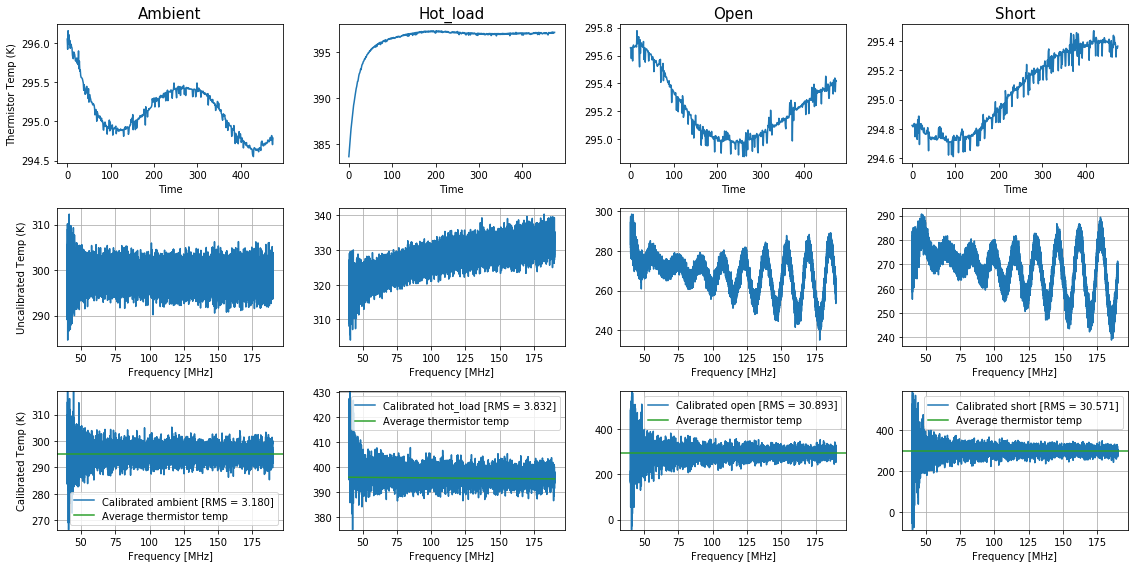

In [ ]:
fig, ax = plt.subplots(
    3,
    4,
    figsize=(16, 8),
)

for i, (name, load) in enumerate(calobs.loads.items()):
    ec.plots.plot_resistance_measurements(io_obs.resistance._loads[name], ax=ax[0, i])
    ax[0, i].set_title(name.capitalize(), fontsize=15)
    ec.plots.plot_raw_spectrum(
        load.spectrum, fig=fig, ax=ax[1, i], ylabel=False, xlabel=False
    )
    calobs.plot_calibrated_temp(load, ax=ax[2, i], ylabel=False)

ax[0, 0].set_ylabel("Thermistor Temp (K)")
ax[1, 0].set_ylabel("Uncalibrated Temp (K)")
ax[2, 0].set_ylabel("Calibrated Temp (K)")

plt.tight_layout()

**Figure 1 | Spectrum Measurements.** Each column is a known input calibrator source. Top row is the measured thermistor temperature in K as a function of time (in number of integrations). Second row is the *uncalibrated* measured temperature of the spectrum, as a function of frequency. The third row is the *calibrated* temperature (see figure 5 for the calibration coefficients) shown against the average thermistor temperature across the band.

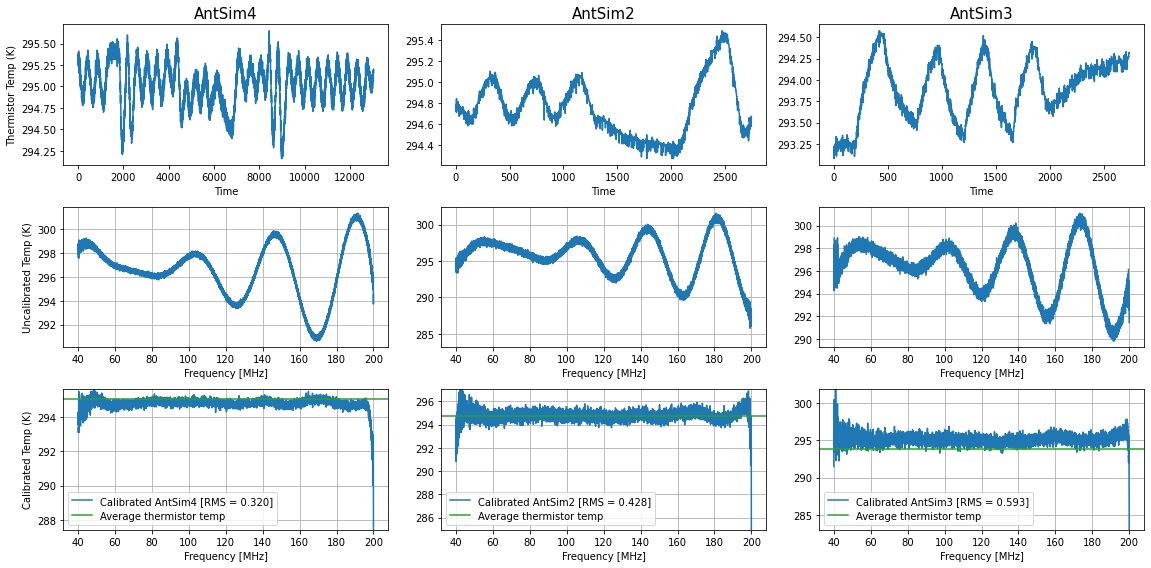

In [ ]:
fig, ax = plt.subplots(3, len(antsims), figsize=(16, 8), squeeze=False)

for i, (name, load) in enumerate(antsims.items()):
    ec.plots.plot_resistance_measurements(
        io_obs.resistance.simulators[name], ax=ax[0, i]
    )
    ax[0, i].set_title(name.capitalize(), fontsize=15)
    ec.plots.plot_raw_spectrum(
        load.spectrum, fig=fig, ax=ax[1, i], ylabel=False, xlabel=False
    )
    calobs.plot_calibrated_temp(load, ax=ax[2, i], ylabel=False)

ax[0, 0].set_ylabel("Thermistor Temp (K)")
ax[1, 0].set_ylabel("Uncalibrated Temp (K)")
ax[2, 0].set_ylabel("Calibrated Temp (K)")

plt.tight_layout()

**Figure 2 | Antenna Simulator Spectra.** This plot shows the same measurements as Figure 1, but for the antenna simulators measured in this calibration.

## S11

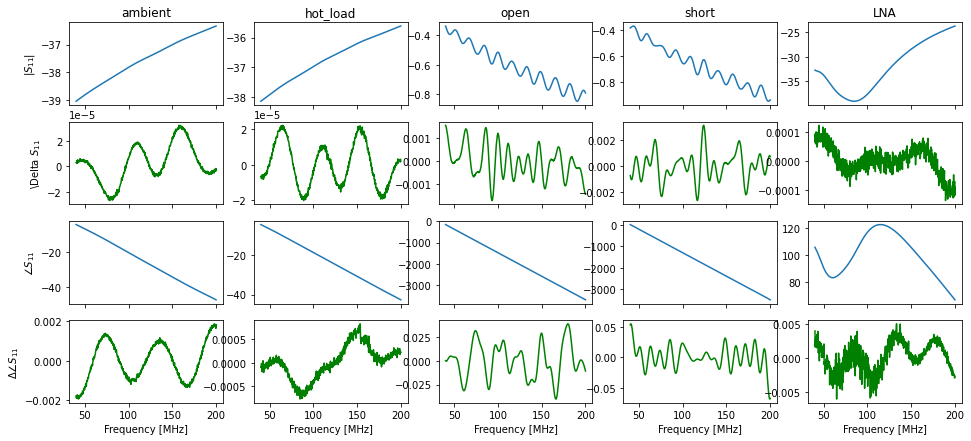

In [7]:
fig, ax = plt.subplots(4, 5, sharex=True, figsize=(16, 7))
warnings.filterwarnings("ignore", category=DeprecationWarning)

for i, (name, source) in enumerate(calobs.loads.items()):
    source.reflections.plot_residuals(
        fig=fig, ax=ax[:, i], title=False, decade_ticks=False, ylabels=not i
    )
    ax[0, i].set_title(name)

calobs.receiver.plot_residuals(
    fig=fig, ax=ax[:, -1], title=False, decade_ticks=False, ylabels=False
)
ax[0, -1].set_title("LNA");

**Figure 3 | Reflection Measurements.** This shows the reflection coefficient, $S_{11}$, for each input calibrator (columns). Top row shows the measured magnitude, second row the error in the model of the magnitude, the third row shows the phase angle and the bottom row shows the error in the magnitude of the phase. 

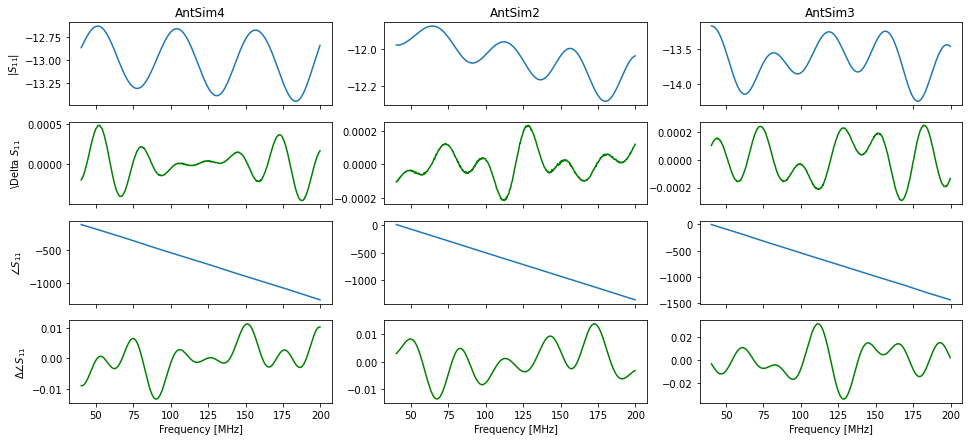

In [20]:
fig, ax = plt.subplots(4, len(antsims), sharex=True, figsize=(16, 7), squeeze=False)
warnings.filterwarnings("ignore", category=DeprecationWarning)

for i, (name, source) in enumerate(antsims.items()):
    source.reflections.plot_residuals(
        fig=fig, ax=ax[:, i], title=False, decade_ticks=False, ylabels=not i
    )
    ax[0, i].set_title(name)

**Figure 4 | Antenna Simulator Reflection Coefficients.** The same as Fig. 3, but for the antenna simulators measured for this calibration observation.

## Calibration

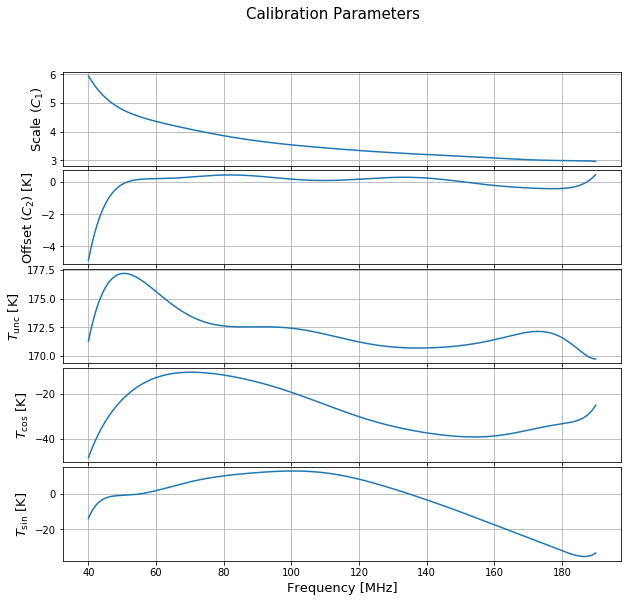

In [20]:
calobs.plot_coefficients();

**Figure 5 | Calibration Coefficients.** This shows the calibration coefficients as a function of frequency, as measured by optimizing the RMS of the calibrated temperatures of the input calibrator sources. The top row shows the overall scaling of the temperature required, the second row shows the overall offset, and the third, fourth and fifth rows show the noise-wave parameters (uncorrelated, cosine and sine).

## All Files Used

In [21]:
import os


def list_files(startpath, filter_list):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(str(startpath), "").count(os.sep)
        indent = " " * 4 * (level)
        ff = [
            f
            for f in files
            if any(str(x).startswith(str(Path(root) / f)) for x in filter_list)
        ]
        dd = [
            d
            for d in dirs
            if any(str(x).startswith(str(Path(root) / d)) for x in filter_list)
        ]
        if ff or dd:
            print(f"{indent}{os.path.basename(root)}/")
        if ff:
            subindent = " " * 4 * (level + 1)
            for f in ff:
                print(f"{subindent}{f}")

In [27]:
fl = io_obs.list_of_files[0]
list_files(obspath.parent, io_obs.list_of_files)

data/
    Receiver01_25C_2019_11_26_040_to_200MHz/
        S11/
            LongCableOpen01/
                External01.s1p
                Short01.s1p
                Match01.s1p
                Open01.s1p
            HotLoad01/
                External01.s1p
                Short01.s1p
                Match01.s1p
                Open01.s1p
            Ambient01/
                External01.s1p
                Short01.s1p
                Match01.s1p
                Open01.s1p
            LongCableShorted01/
                External01.s1p
                Short01.s1p
                Match01.s1p
                Open01.s1p
        Resistance/
            HotLoad_01_2019_330_16_38_16_lab.csv
            Ambient_01_2019_329_16_02_35_lab.csv
            LongCableShorted_01_2019_333_13_17_29_lab.csv
            LongCableOpen_01_2019_334_11_43_15_lab.csv
        Spectra/
            LongCableOpen_01_2019_334_18_43_21_lab.acq
            LongCableShorted_01_2019_333_20_17_28_lab.acq
            